# Building the EchoScope Model - 2

In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
IQ_Processed = np.load('../data/processed_iq_data.npz')
Spectrogram_Processed = np.load('../data/spectrograms.npz')

In [4]:
X_list = []
y_list = []

for key_str in IQ_Processed.files:
    key = ast.literal_eval(key_str)
    mod_name = key[0]
    data = IQ_Processed[key_str]
    
    X_list.append(data)
    y_list.extend([mod_name] * data.shape[0])

X = np.vstack(X_list)
y = np.array(y_list)

print(f'Total samples: {X.shape[0]}')
print(f'Unique modulations: {np.unique(y)}')


Total samples: 220000
Unique modulations: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [16]:
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 128), (132000,)
Validation shape: (44000, 2, 128), (44000,)
Test shape: (44000, 2, 128), (44000,)


In [6]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)

print(LE.classes_)

['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [8]:
train_dataset_time = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_time = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_time = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_time = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_time = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_time = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [9]:
class Time_Series_Model(nn.Module):
    def __init__(self, input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5):
        super(Time_Series_Model, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.0  
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        return out

In [10]:
Time_Series_Model_V1 = Time_Series_Model()
Time_Series_Model_V1 = Time_Series_Model_V1.to(device)

In [11]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [12]:
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                labels = batch[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

In [13]:
optimizer = optim.Adam(Time_Series_Model_V1.parameters(), lr=0.0001)
train_losses, val_losses = train_model(model=Time_Series_Model_V1, criterion=nn.CrossEntropyLoss(), 
            optimizer=optimizer, epochs=50, train_loader=train_loader_time, 
            val_loader=val_loader_time)

Epoch 1/50 | Train Loss: 2.392177 | Val Loss: 2.360889
Epoch 2/50 | Train Loss: 2.332988 | Val Loss: 2.285662
Epoch 3/50 | Train Loss: 2.258777 | Val Loss: 2.202439
Epoch 4/50 | Train Loss: 2.194615 | Val Loss: 2.143412
Epoch 5/50 | Train Loss: 2.151259 | Val Loss: 2.106950
Epoch 6/50 | Train Loss: 2.124299 | Val Loss: 2.083766
Epoch 7/50 | Train Loss: 2.105048 | Val Loss: 2.068704
Epoch 8/50 | Train Loss: 2.094096 | Val Loss: 2.058155
Epoch 9/50 | Train Loss: 2.083782 | Val Loss: 2.050130
Epoch 10/50 | Train Loss: 2.075458 | Val Loss: 2.043991
Epoch 11/50 | Train Loss: 2.068366 | Val Loss: 2.038920
Epoch 12/50 | Train Loss: 2.061923 | Val Loss: 2.034720
Epoch 13/50 | Train Loss: 2.056171 | Val Loss: 2.031050
Epoch 14/50 | Train Loss: 2.052155 | Val Loss: 2.028000
Epoch 15/50 | Train Loss: 2.047121 | Val Loss: 2.025035
Epoch 16/50 | Train Loss: 2.042046 | Val Loss: 2.022561
Epoch 17/50 | Train Loss: 2.038588 | Val Loss: 2.020028
Epoch 18/50 | Train Loss: 2.035754 | Val Loss: 2.018178
E

### Hyperparameter Trials: 

#### Trial 1: Complex model w/o dropout
The model overfitted with the following hyperparameters: input_size=128, hidden_size=64, output_size=11, num_layers=1, dropout=0, learning_rate=0.0001, optimizer=Adam, loss_fn=CrossEntropyLoss, epochs=50, using a bidirectional LSTM without effective dropout due to num_layers=1.

#### Trial 2: Complex model w/ dropout
The model previously overfitted using the following configuration: input_size=128, hidden_size=64, output_size=11, num_layers=2, dropout=0.5, bidirectional=True, learning_rate=0.0001, optimizer=Adam, and CrossEntropyLoss. Despite enabling both internal and external dropout, validation loss steadily increased while training loss decreased, indicating the model capacity was too high for the dataset. This prompted a simplification of the architecture to reduce overfitting risk.

#### Trial 3: Simplified model w/dropout
The simplified model (input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5, bidirectional=False, learning_rate=0.0001) showed significantly improved generalization compared to the previous overfitted configuration. Both training and validation loss decreased steadily over 50 epochs, confirming that reducing model complexity effectively mitigated overfitting and led to stable convergence.

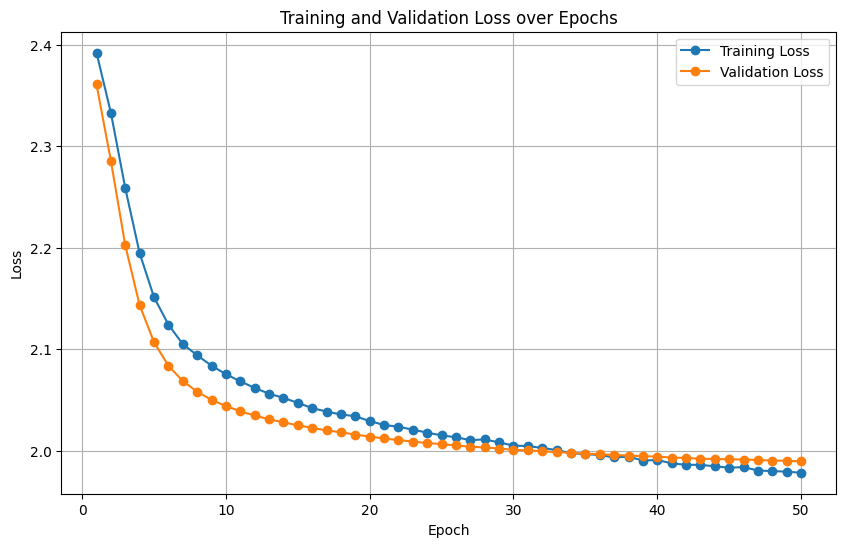

In [15]:
epochs = range(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
keys = Spectrogram_Processed.files
print(keys)

key_example = "('QPSK', 2)"
if key_example in keys:
    data = Spectrogram_Processed[key_example]
    print(f"Data shape for {key_example}:", data.shape)
else:
    print(f"{key_example} not found in the file.")

["('QPSK', 2)", "('PAM4', 8)", "('AM-DSB', -4)", "('GFSK', 6)", "('QAM64', 8)", "('AM-SSB', 12)", "('8PSK', 8)", "('8PSK', 12)", "('QAM64', -6)", "('QAM16', 2)", "('QAM16', -20)", "('PAM4', -6)", "('WBFM', -18)", "('AM-DSB', 16)", "('CPFSK', 10)", "('WBFM', 6)", "('BPSK', 4)", "('BPSK', -2)", "('QPSK', -20)", "('CPFSK', -8)", "('AM-SSB', 6)", "('QAM64', -20)", "('QAM16', 12)", "('GFSK', -20)", "('AM-SSB', -12)", "('CPFSK', 0)", "('AM-DSB', 6)", "('BPSK', -16)", "('QPSK', -6)", "('8PSK', -12)", "('CPFSK', -18)", "('BPSK', -10)", "('QPSK', 8)", "('PAM4', 14)", "('AM-DSB', -10)", "('GFSK', 12)", "('QAM64', 2)", "('WBFM', -4)", "('AM-SSB', -18)", "('QAM64', -4)", "('GFSK', -4)", "('AM-DSB', 8)", "('PAM4', -16)", "('QPSK', -16)", "('BPSK', 16)", "('8PSK', -8)", "('CPFSK', 16)", "('WBFM', 0)", "('QPSK', 6)", "('BPSK', 14)", "('AM-DSB', -8)", "('GFSK', -10)", "('CPFSK', -2)", "('AM-SSB', 8)", "('GFSK', 18)", "('QAM16', 6)", "('QAM16', -16)", "('QAM64', 18)", "('AM-SSB', -2)", "('CPFSK', 6)", 

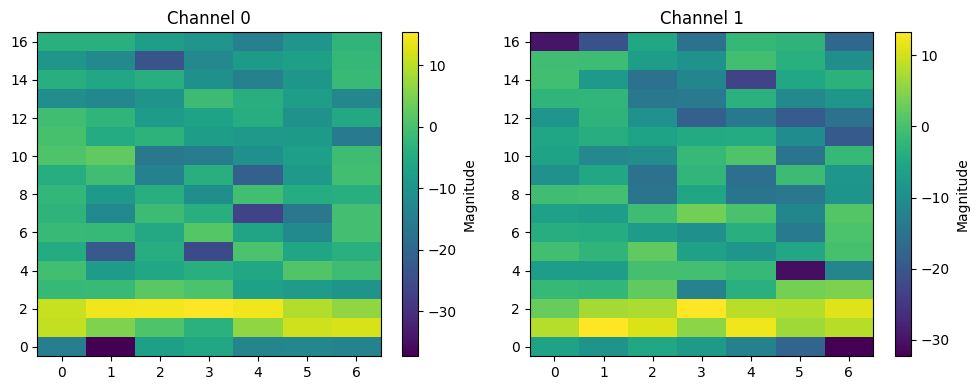

In [22]:
example = data[0] 
plt.figure(figsize=(10,4))
for ch in range(example.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f'Channel {ch}')
    plt.imshow(example[ch], aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [23]:
all_data_spect = []
all_labels_spect = []
label_map = {k: i for i, k in enumerate(keys)}
for key in keys:
    data = Spectrogram_Processed[key]
    all_data_spect.append(data)
    
    labels = np.full(data.shape[0], label_map[key])
    all_labels_spect.append(labels)

X = np.concatenate(all_data_spect, axis=0)
y = np.concatenate(all_labels_spect, axis=0)

print(f"Combined data shape: {X.shape}")
print(f"Combined labels shape: {y.shape}")

Combined data shape: (220000, 2, 17, 7)
Combined labels shape: (220000,)


In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 17, 7), (132000,)
Validation shape: (44000, 2, 17, 7), (44000,)
Test shape: (44000, 2, 17, 7), (44000,)
